An experiment involving SVM on signed barcodes of 2-parameter persistence modules.

In [ ]:
from MPHvect.method import *


try:
    import persim
except ImportError:
    print("persim not installed — some examples may fail.")
try:
    import multipers
except ImportError:
    print("Multipers not installed — some examples may fail.")

from persim import plot_diagrams
from ripser import ripser
import multipers.plots as mpp
from multipers.filtrations import RipsLowerstar, RipsCodensity

In [2]:
#make sampling methods


def sample_annulus(n_points, r_inner, r_outer, noise=0.0, center=(0,0)):
    """
    Sample points uniformly from an annulus with inner radius r_inner and outer radius r_outer.
    Optionally add Gaussian noise.
    """
    theta = np.random.uniform(0, 2*np.pi, n_points)
    r = np.sqrt(np.random.uniform(r_inner**2, r_outer**2, n_points))
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    points = np.column_stack([x, y])

    if noise > 0:
        points += np.random.normal(scale=noise, size=points.shape)

    return points

def sample_disk(n_points, radius, noise=0.0, center=(0,0)):
    """
    Sample points uniformly from a disk with given radius.
    Optionally add Gaussian noise.
    """
    theta = np.random.uniform(0, 2*np.pi, n_points)
    r = np.sqrt(np.random.uniform(0, radius**2, n_points))
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    points = np.column_stack([x, y])

    if noise > 0:
        points += np.random.normal(scale=noise, size=points.shape)

    return points

def generate_two_annuli_and_disk(n, r11,r12,r21, r22,r3,noise=0.05):
    """

    Generate points for two non-overlapping annuli and a disk.
    """
    area1=(np.pi*(r12**2-r11**2))
    area2=(np.pi*(r22**2-r21**2))
    area3=(np.pi*(r3**2))
    total_area=area1+area2+area3
    n1 = int(n*0.6*area1/total_area)
    n2 = int(n*0.6*area2/total_area)
    n_disk = int(n*0.6*area3/total_area)
    n_noise=n-n1-n2-n_disk

    # Annulus 1 (centered at origin)
    annulus1 = sample_annulus(n1, r_inner=r11, r_outer=r12, noise=noise, center=(-1,-1))

    # Annulus 2 (shifted so it does not overlap)
    annulus2 = sample_annulus(n2, r_inner=r21, r_outer=r22, noise=noise, center=(1,0))

    # Disk (shifted so it does not overlap)
    disk_points = sample_disk(n_disk, radius=r3, noise=noise, center=(-0.8,1.2))
    more_noise= np.random.uniform(low=-2, high=2, size=(n_noise,2))

    return np.vstack([annulus1, annulus2, disk_points, more_noise])

def generate_three_annuli(n, r11, r12, r21, r22, r31, r32, noise=0.15):
    """

    Generate points for two non-overlapping annuli and a disk.
    """
    area1=(np.pi*(r12**2-r11**2))
    area2=(np.pi*(r22**2-r21**2))
    area3=(np.pi*(r32**2-r31**2))
    total_area=area1+area2+area3
    n1 = int(n*0.5*area1/total_area)
    n2 = int(n*0.5*area2/total_area)
    n3= int(n*0.5*area3/total_area)
    n_noise=n-n1-n2-n3
    # Annulus 1 (centered at origin)
    annulus1 = sample_annulus(n1, r_inner=r11, r_outer=r12, noise=noise, center=(-1,-1))

    # Annulus 2 (shifted so it does not overlap)
    annulus2 = sample_annulus(n2, r_inner=r21, r_outer=r22, noise=noise, center=(1,0))

    # Annulus 3 (shifted so it does not overlap)
    annulus3= sample_annulus(n3, r_inner=r31, r_outer=r32, noise=noise, center=(-0.8,1.2))
    more_noise= np.random.uniform(low=-2, high=2, size=(n_noise,2))

    return np.vstack([annulus1, annulus2, annulus3, more_noise])



In [5]:

class1_points=[]
for i in range(100):
  np.random.seed(i)
  class1_points.append(generate_two_annuli_and_disk(750,0.2,0.45, 0.3, 0.55, 0.7, noise=0.15))

class2_points=[]
for i in range(100):
  np.random.seed(i)
  class2_points.append(generate_three_annuli(750,0.2,0.45, 0.3, 0.55, 0.45, 0.7, noise=0.15))



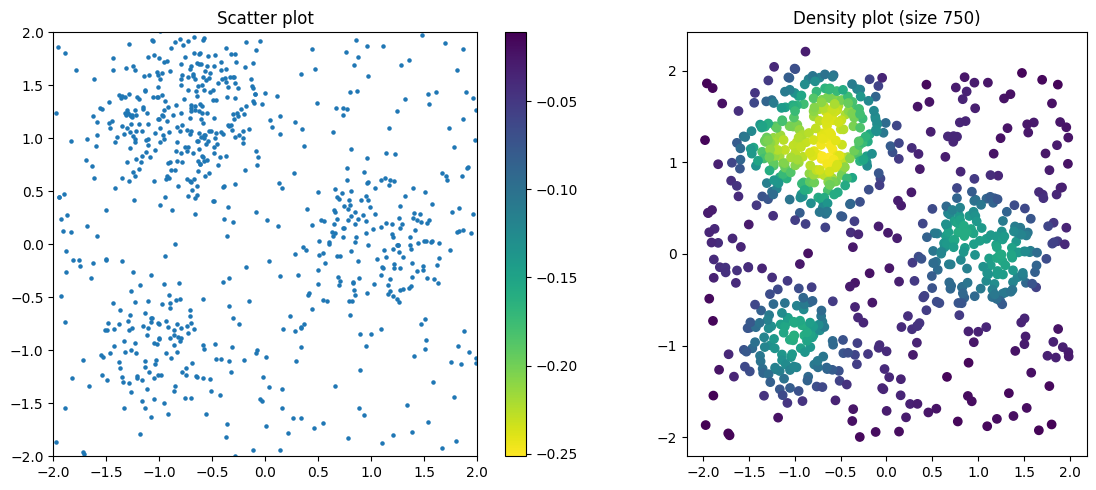

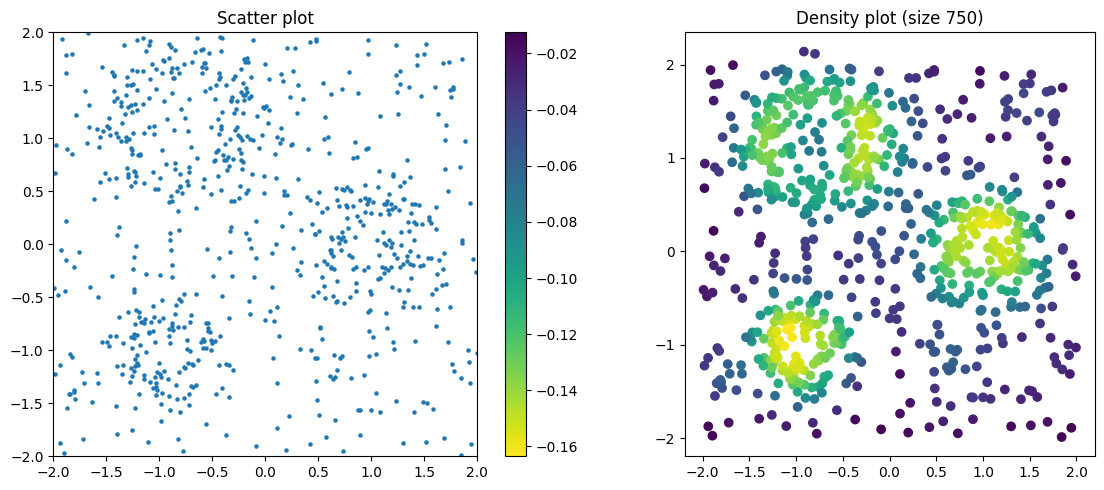

In [12]:
#Here we plot the first sampling in the first class of points. This consists of points sampled from two disjoint annuli, a third disk (also disjoint), and significant random points in the sampling space.

points =class1_points[0]
kde = KernelDensity(kernel="gaussian", bandwidth=0.2)
kde.fit(points)

# 2. Evaluate log density at the same points
log_density = kde.score_samples(points)  # returns log-density

# 3. Convert to normal density if needed
density = np.exp(log_density)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Figure 2 (right): simple scatter ---
axes[0].scatter(points[:, 0], points[:, 1], s=5)
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect(1)
axes[0].set_title("Scatter plot")

# --- Figure 1 (left): density-colored scatter ---
sc = axes[1].scatter(points[:, 0], points[:, 1], c=-density, cmap="viridis_r")
axes[1].set_aspect(1)
axes[1].set_title(f"Density plot (size {points.shape[0]})")
fig.colorbar(sc, ax=axes[0])



plt.tight_layout()
plt.show()


#Now we do the same thing for the first sampling of the second class of points

points=class2_points[1]
kde = KernelDensity(kernel="gaussian", bandwidth=0.2)
kde.fit(points)

# 2. Evaluate log density at the same points
log_density = kde.score_samples(points)  # returns log-density

# 3. Convert to normal density if needed
density = np.exp(log_density)

# Create 1 row, 2 columns of plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Figure 2 (right): simple scatter ---
axes[0].scatter(points[:, 0], points[:, 1], s=5)
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect(1)
axes[0].set_title("Scatter plot")

# --- Figure 1 (left): density-colored scatter ---
sc = axes[1].scatter(points[:, 0], points[:, 1], c=-density, cmap="viridis_r")
axes[1].set_aspect(1)
axes[1].set_title(f"Density plot (size {points.shape[0]})")
fig.colorbar(sc, ax=axes[0])



plt.tight_layout()
plt.show()

In [ ]:
#Now compute signed barcodes
import sys
class1_barcodes=[]
for i, points in enumerate(class1_points):
  density = KDE(bandwidth=0.15, return_log=True).fit(points).score_samples(points)
  simplextree = RipsLowerstar(points=points, function = 1-density, threshold_radius=2.5) # this is a simplicial complex
  simplextree.collapse_edges(-2)                             # Removes some unnecessary edges (while staying quasi isomorphic)
  simplextree.expansion(2)                                   # Adds the 2-simplices (necessary for $H_1$ computations)
  simplextree.prune_above_dimension(2) ## The simplices above dimension 2 are not necessary here; this speeds up the computations.
  grid = mp.grids.compute_grid( ## Computes a subgrid
      simplextree,
      strategy="regular", # i.e., will return a regular grid
      resolution=50,
  )
  rank_sm = mp.signed_measure(
      simplextree.grid_squeeze(grid), # we coarsen the simplextree before feeding it to the invariant computation
      degree=1,
      invariant = "rank", # The default one is using rectangle decompositions.
      plot = False,
  );
  class1_barcodes.append(rank_sm[0])
  sys.stdout.write(f"\rCompleted {i+1}/100")
  sys.stdout.flush()

print()




class2_barcodes=[]
for i, points in enumerate(class2_points):
  density = KDE(bandwidth=0.15, return_log=True).fit(points).score_samples(points)
  simplextree = RipsLowerstar(points=points, function = 1-density, threshold_radius=2.5) # this is a simplicial complex
  simplextree.collapse_edges(-2)                             # Removes some unnecessary edges (while staying quasi isomorphic)
  simplextree.expansion(2)                                   # Adds the 2-simplices (necessary for $H_1$ computations)
  simplextree.prune_above_dimension(2) ## The simplices above dimension 2 are not necessary here; this speeds up the computations.
  grid = mp.grids.compute_grid( ## Computes a subgrid
      simplextree,
      strategy="regular", # i.e., will return a regular grid
      resolution=50,
  )
  rank_sm = mp.signed_measure(
      simplextree.grid_squeeze(grid), # we coarsen the simplextree before feeding it to the invariant computation
      degree=1,
      invariant = "rank", # The default one is using rectangle decompositions.
      plot = False,
  );
  class2_barcodes.append(rank_sm[0])
  sys.stdout.write(f"\rCompleted {i+1}/100")
  sys.stdout.flush()

print()

Completed 3/100

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x112d1e410>>
Traceback (most recent call last):
  File "/Users/zachthomas/projects/multipers_project/myenviro/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
#Here, we normalize the barcodes to fit inside the unit 4D-cube

max_val_1=max(max(arr[np.isfinite(arr)].max() for arr in barcode[0]) for barcode in class1_barcodes)
max_val_2=max(max(arr[np.isfinite(arr)].max() for arr in barcode[0]) for barcode in class2_barcodes)
max_val=max(max_val_1,max_val_2)

for i,b in enumerate(class1_barcodes):
    bars,mults=b
    penultimate_bars=0.9*(max_val**-1)*bars
    normed_bars=replace_inf_safe(penultimate_bars)

    class1_barcodes[i]=(normed_bars,mults)
    sys.stdout.write(f"\rCompleted {i+1}/100")
    sys.stdout.flush()
print()

for i,b in enumerate(class2_barcodes):
    bars,mults=b
    max_val = max(arr[np.isfinite(arr)].max() for arr in bars)

    penultimate_bars=0.9*(max_val**-1)*bars
    normed_bars=replace_inf_safe(penultimate_bars)
    class2_barcodes[i]=(normed_bars,mults)
    sys.stdout.write(f"\rCompleted {i+1}/100")
    sys.stdout.flush()
print()

Completed 100/100
Completed 100/100


In [ ]:
#Now vectorize all these barcodes using our method(remember to account for multiplicities)



n_list, p_list=collect_vertices(2, 5)
class1_vectors=[]
for i,barcode in enumerate(class1_barcodes):
  class1_vectors.append(vectorize_fast(n_list, p_list, barcode[0], barcode[1]))
  sys.stdout.write(f"\rCompleted {i+1}/100")
  sys.stdout.flush()
print()

class2_vectors=[]
for i,barcode in enumerate(class2_barcodes):
  class2_vectors.append(vectorize_fast(n_list, p_list, barcode[0], barcode[1]))
  sys.stdout.write(f"\rCompleted {i+1}/100")
  sys.stdout.flush()
print()



Completed 100/100
Completed 100/100


SVM Accuracy: 0.85


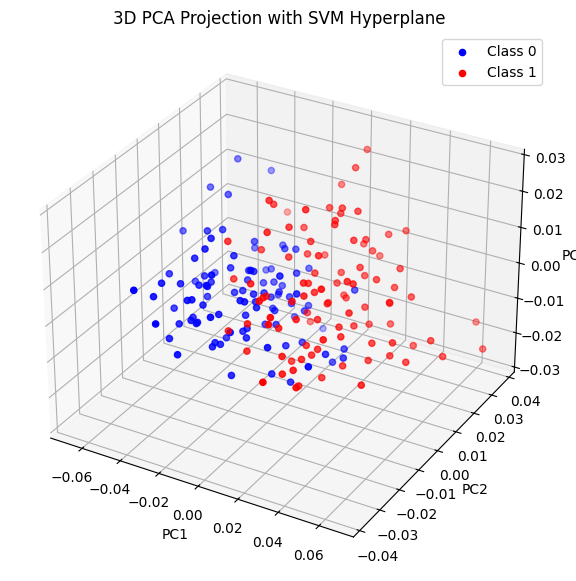

In [ ]:

do_SVM_and_PCA(np.array(class1_vectors), np.array(class2_vectors))